In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
os.chdir('/content/drive/MyDrive/DEBUSA')

In [5]:
training_data = '/content/drive/MyDrive/DEBUSA/Training'
validation_data = '/content/drive/MyDrive/DEBUSA/Validation'
testing_data = '/content/drive/MyDrive/DEBUSA/Testing'

In [6]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

valid_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
    training_data,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_directory(
    validation_data,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

test_generator = valid_datagen.flow_from_directory(
    testing_data,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 2474 images belonging to 10 classes.
Found 1794 images belonging to 10 classes.
Found 2479 images belonging to 10 classes.


In [7]:
# Membuat model
base_model = InceptionV3(weights='imagenet', include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(10, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

87910968/87910968 [==============================] - 0s 0us/step


In [ ]:
# Melatih model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // valid_generator.batch_size,
    epochs=10
)

Epoch 1/10
77/77 [==============================] - 1647s 21s/step - loss: 0.9965 - accuracy: 0.8182 - val_loss: 0.1882 - val_accuracy: 0.9436
Epoch 2/10
77/77 [==============================] - 164s 2s/step - loss: 0.1985 - accuracy: 0.9349 - val_loss: 0.1424 - val_accuracy: 0.9565
Epoch 3/10
77/77 [==============================] - 163s 2s/step - loss: 0.1284 - accuracy: 0.9590 - val_loss: 0.1036 - val_accuracy: 0.9598
Epoch 4/10
77/77 [==============================] - 163s 2s/step - loss: 0.1273 - accuracy: 0.9578 - val_loss: 0.1044 - val_accuracy: 0.9688
Epoch 5/10
77/77 [==============================] - 157s 2s/step - loss: 0.1058 - accuracy: 0.9668 - val_loss: 0.0876 - val_accuracy: 0.9648
Epoch 6/10
77/77 [==============================] - 171s 2s/step - loss: 0.0851 - accuracy: 0.9693 - val_loss: 0.0771 - val_accuracy: 0.9754
Epoch 7/10
77/77 [==============================] - 172s 2s/step - loss: 0.0661 - accuracy: 0.9812 - val_loss: 0.0441 - val_accuracy: 0.9855
Epoch 8/10


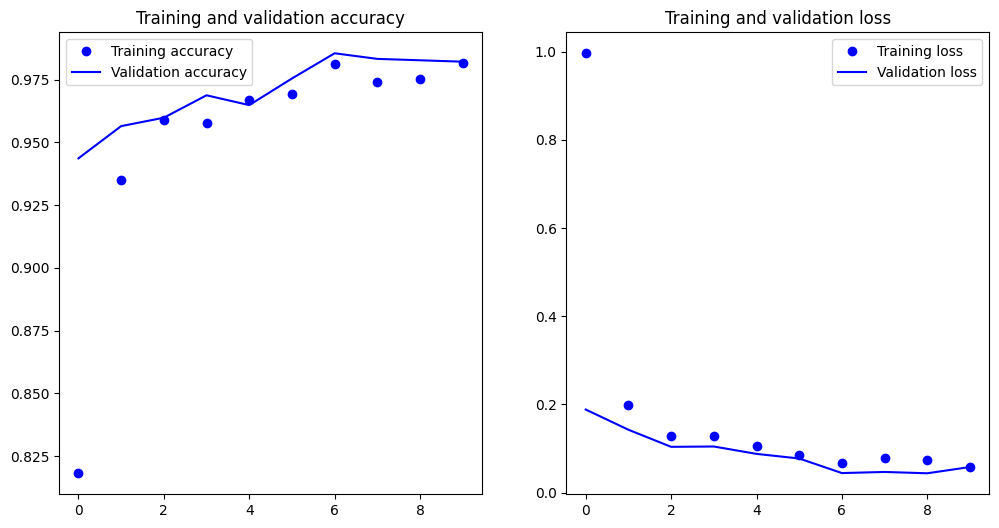

In [9]:
# Plotting akurasi dan loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [11]:
# Prediksi label dari gambar uji
pred_test = model.predict(test_generator)
pred_test = np.argmax(pred_test, axis=1)

78/78 [==============================] - 942s 12s/step


In [12]:
# Map the label
labels = (test_generator.class_indices)
labels = dict((v, k) for k, v in labels.items())
pred_test = [labels[k] for k in pred_test]

# Tampilkan hasil prediksi pertama
print(f'The first 5 predictions: {pred_test[:5]}')

The first 5 predictions: ['APEL', 'APEL', 'APEL', 'APEL', 'APEL']


1/1 [==============================] - 0s 60ms/step


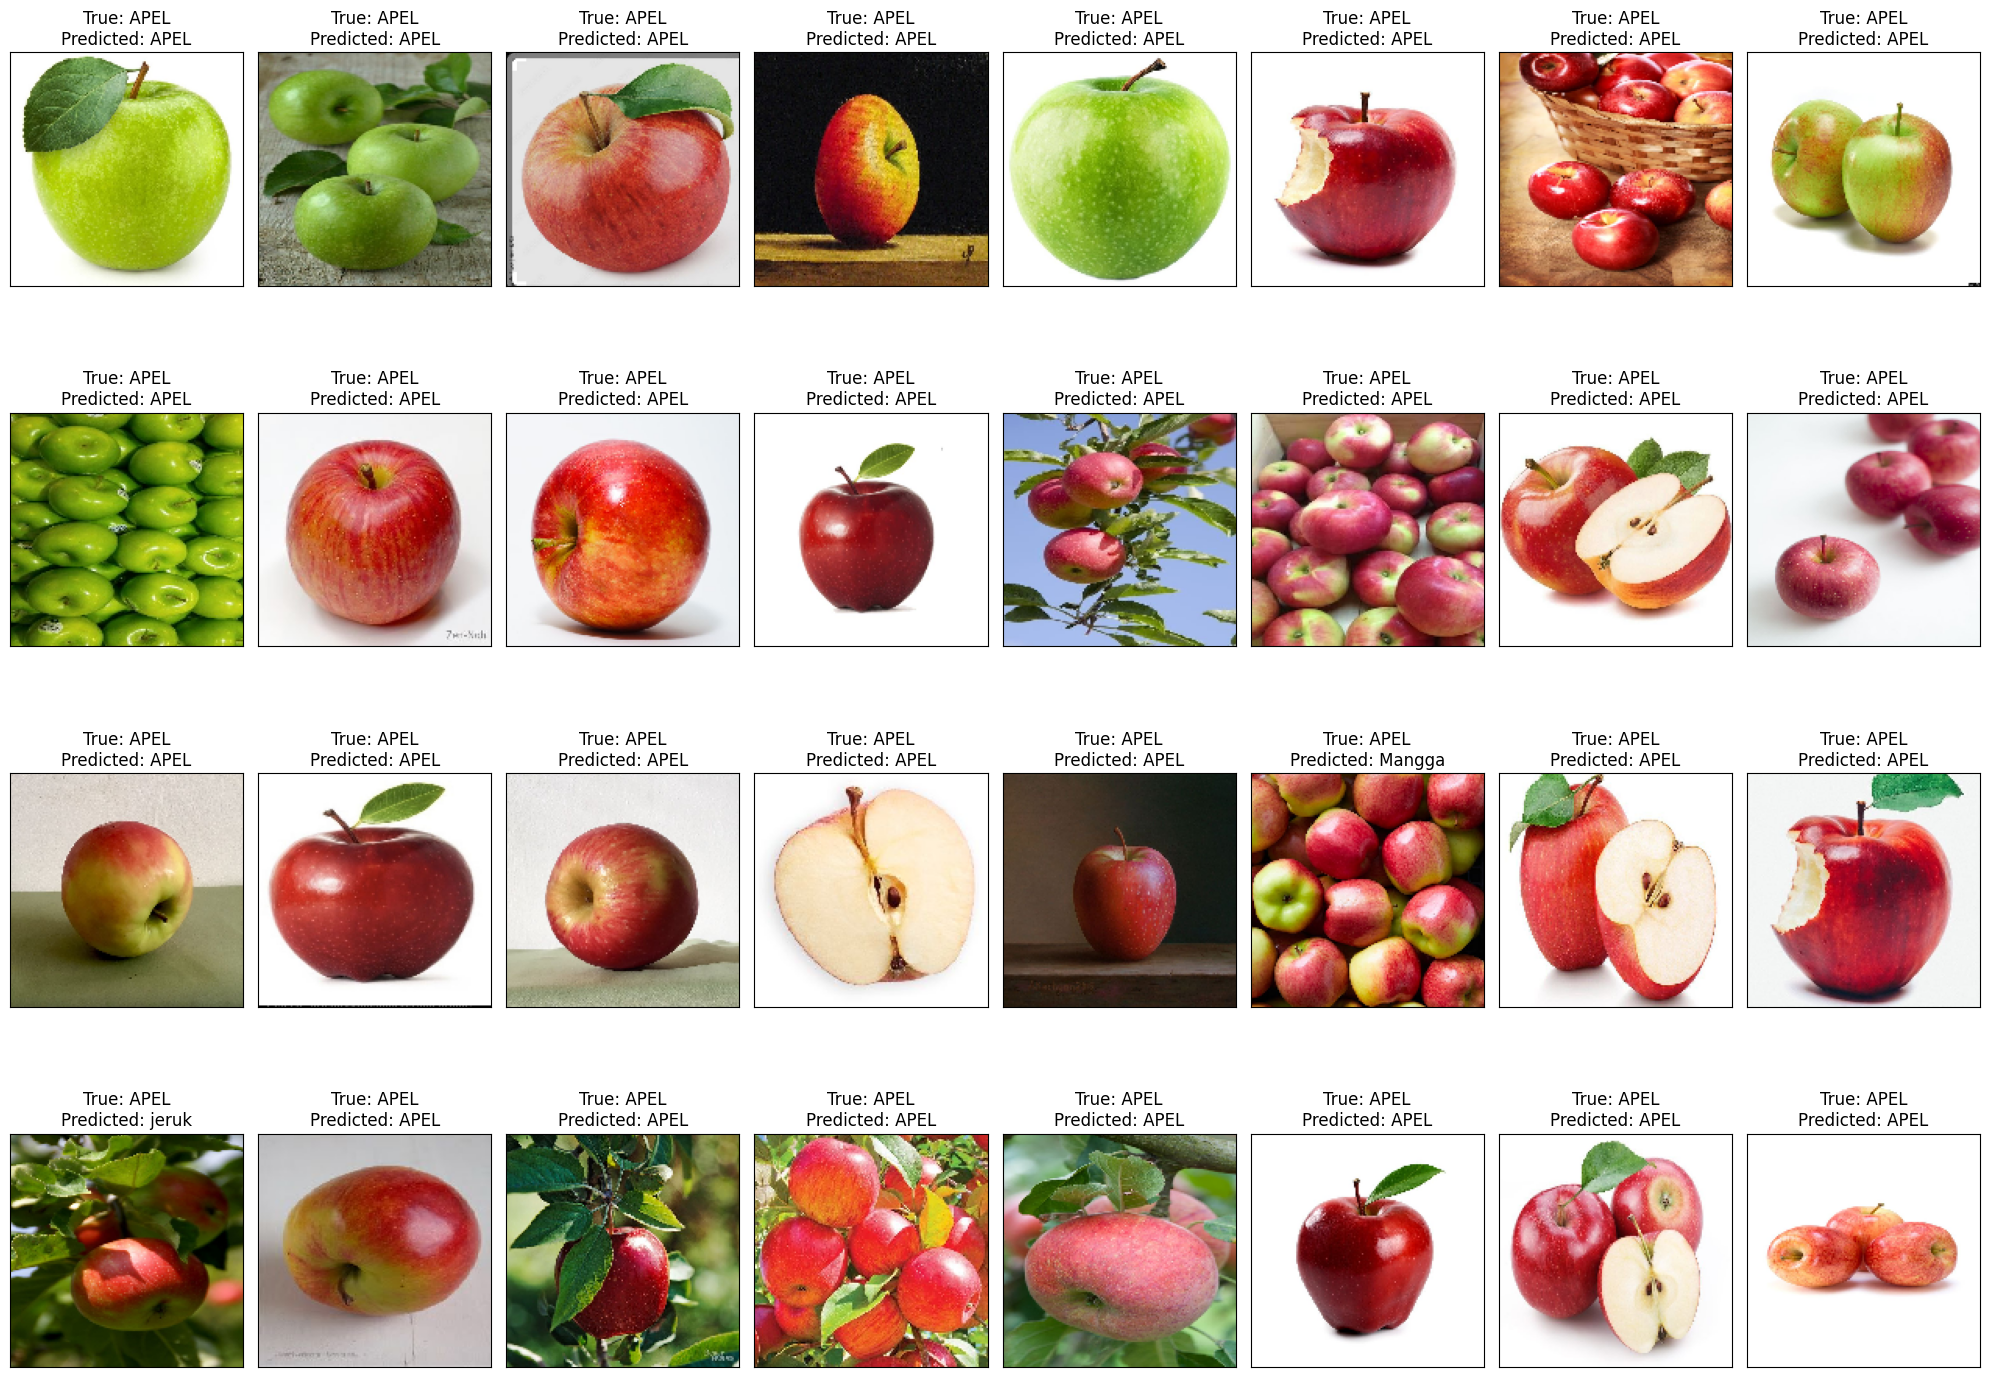

In [13]:
# Menampilkan beberapa gambar dari dataset dengan prediksi
x_test, y_test = next(test_generator)
pred_test = model.predict(x_test)
pred_test_labels = np.argmax(pred_test, axis=1)
true_labels = np.argmax(y_test, axis=1)

label_map = train_generator.class_indices
label_map = dict((v,k) for k,v in label_map.items())
pred_test_labels = [label_map[k] for k in pred_test_labels]
true_labels = [label_map[k] for k in true_labels]

fig, axes = plt.subplots(nrows=4, ncols=8, figsize=(20, 15), subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    if i < len(x_test):
        ax.imshow(x_test[i])
        ax.set_title(f"True: {true_labels[i]}\nPredicted: {pred_test_labels[i]}")
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()

In [17]:
model.save('/content/drive/MyDrive/DEBUSA/Model/DEBUSA_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [19]:
import tensorflow as tf
import numpy as np
from keras.preprocessing import image
import os
from google.colab import files

# Load trained model
model = tf.keras.models.load_model("/content/drive/MyDrive/DEBUSA/Model/DEBUSA_model.h5")

# Path to directory containing class labels
train_dir = "/content/drive/MyDrive/DEBUSA/Training"
class_list = sorted(os.listdir(train_dir))

# Function to process image and make prediction
def predict_image(img):
    # Preprocess image
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = x / 255.0  # Normalize pixel values

    # Perform prediction
    predictions = model.predict(x)

    # Get predicted class label
    predicted_class_index = np.argmax(predictions)
    predicted_class = class_list[predicted_class_index]

    return predicted_class, predictions[0]

# Upload image
uploaded = files.upload()

# Process and predict class label for each uploaded image
for fn in uploaded.keys():
    # Load and preprocess uploaded image
    img = image.load_img(fn, target_size=(224, 224))

    # Predict class label
    predicted_class, confidence_scores = predict_image(img)

    # Display prediction result
    print("Image:", fn)
    print("Predicted Class:", predicted_class)
    print("Confidence Scores:", confidence_scores)
    print()


Saving Wortel.jpg to Wortel.jpg
1/1 [==============================] - 1s 1s/step
Image: Wortel.jpg
Predicted Class: wortel
Confidence Scores: [4.3813849e-04 1.0230645e-03 6.9839507e-03 3.1238032e-04 8.6621422e-04
 1.0657864e-02 4.2252339e-04 7.0838042e-04 3.1687622e-04 9.7827065e-01]

